<a href="https://colab.research.google.com/github/LAguirr/CNN/blob/main/UCBM_MnistFULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Unsupervised Concept Discovery

---



In [1]:
# !pip install torch torchvision scikit-learn matplotlib
#!pip install Craft-xai
!pip install git+https://github.com/LAguirr/Craft.git
#!pip install git+https://github.com/lmb-freiburg/ucbm.git

  Cloning https://github.com/LAguirr/Craft.git to /tmp/pip-req-build-1zjmnbmg
  Running command git clone --filter=blob:none --quiet https://github.com/LAguirr/Craft.git /tmp/pip-req-build-1zjmnbmg
  Resolved https://github.com/LAguirr/Craft.git to commit 48b0a4bb16007b73dd5be52da833af17900a6a3c
  Preparing metadata (setup.py) ... done
  Created wheel for Craft-xai: filename=Craft_xai-0.0.3-py3-none-any.whl size=18587 sha256=f3b29faf6dc4a82c9db017021f11fcc4db158c56bd9e34fa5bfff318ee060d6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzk9_h2p/wheels/0d/f3/50/4f7fbd335b2b65d345aedfa53322e43994f0d3878a19628564
Successfully built Craft-xai


In [2]:
!pip install opencv-python
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 7.1 MB/s eta 0:00:00


In [3]:
!pip install datautils

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
### General libraries
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.decomposition import NMF

#Stuff
from torchvision import transforms
from torch.utils.data import ConcatDataset, random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset
import torch.nn.functional as F


#Datasets from Pytorch
from torchvision.datasets import MNIST

In [5]:
import cv2

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.29MB/s]


Dataset MNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: ToTensor()
Percentage training:  0.8571428571428571
Percentage test:  0.14285714285714285
Labels shape:  (70000,)
[6903 7877 6990 7141 6824 6313 6876 7293 6825 6958]


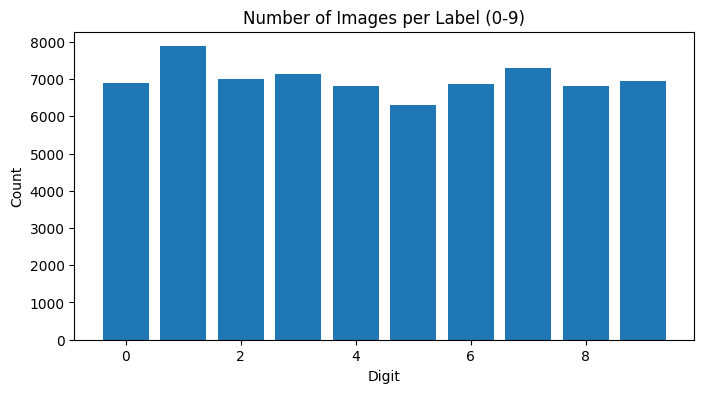

In [7]:
# Download and transform MNIST
"""transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a small validation set from training data
indices = list(range(len(train_dataset)))
train_indices, val_indices = indices[5000:], indices[:5000]

train_loader = DataLoader(Subset(train_dataset, train_indices), batch_size=64, shuffle=True)
val_loader = DataLoader(Subset(train_dataset, val_indices), batch_size=64, shuffle=False)
test_loader = DataLoader(Subset(test_dataset), batch_size=64, shuffle=False)
"""

##COPY FROM THE OTHER NOTEBOOK

transform = transforms.ToTensor()
root = os.getcwd()
dataset_train = MNIST(root=root, download=True, train=True, transform=transform)
dataset_test = MNIST(root=root, download=True, train=False, transform=transform)
print(dataset_train)
print(dataset_test)

# Get labels as numpy array for stratification
labels_train = dataset_train.targets.numpy()
labels_test = dataset_test.targets.numpy()

labels = np.concatenate([labels_train,labels_test])
print("Percentage training: ", len(labels_train)/len(labels))
print("Percentage test: ", len(labels_test)/len(labels))

full_dataset = ConcatDataset([dataset_train, dataset_test])
print("Labels shape: ",labels.shape)
counts = np.bincount(labels, minlength=10)
print(counts)

plt.figure(figsize=(8, 4))
plt.bar(range(10), counts)
plt.title("Number of Images per Label (0-9)")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

Train labels:  [5522 6302 5592 5713 5459 5050 5501 5834 5460 5567]
Validation labels:  [691 788 699 714 682 631 687 730 682 696]
Test labels:  [690 787 699 714 683 632 688 729 683 695]


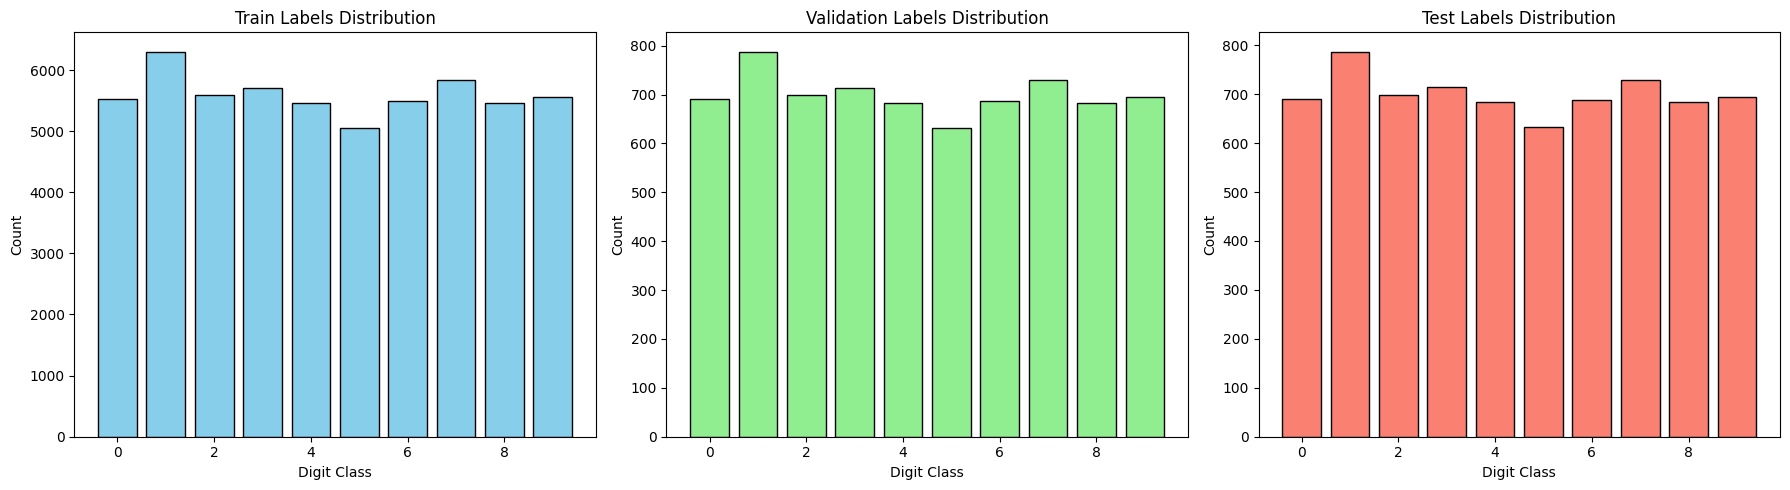

In [8]:
train_idx, temp_idx, _, temp_labels = train_test_split(
    range(len(full_dataset)), labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
train_labels = np.bincount(_, minlength=10)


val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

val_labels = np.bincount(val_labels, minlength=10)
test_labels = np.bincount(test_labels, minlength=10)


print("Train labels: ", train_labels)
print("Validation labels: ", val_labels)
print("Test labels: ", test_labels)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
classes = [0,1,2,3,4,5,6,7,8,9]

# Plot 1: Train Labels
axs[0].bar(classes, train_labels, color='skyblue', edgecolor='black')
axs[0].set_title('Train Labels Distribution')
axs[0].set_xlabel('Digit Class')
axs[0].set_ylabel('Count')

# Plot 2: Validation Labels
axs[1].bar(classes, val_labels, color='lightgreen', edgecolor='black')
axs[1].set_title('Validation Labels Distribution')
axs[1].set_xlabel('Digit Class')
axs[1].set_ylabel('Count')

# Plot 3: Test Labels
axs[2].bar(classes, test_labels, color='salmon', edgecolor='black')
axs[2].set_title('Test Labels Distribution')
axs[2].set_xlabel('Digit Class')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
test_ds  = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

In [9]:
#https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/Craft/craft/craft_torch.py#L28
def _batch_inference(model, dataset, batch_size=128, resize=None, device='cuda'):
  nb_batchs = ceil(len(dataset) / batch_size)
  start_ids = [i*batch_size for i in range(nb_batchs)]

  results = []

  with torch.no_grad():
    for i in start_ids:
      x = torch.tensor(dataset[i:i+batch_size])
      x = x.to(device)

      if resize:
        x = torch.nn.functional.interpolate(x, size=resize, mode='bilinear', align_corners=False)

      results.append(model(x).cpu())

  results = torch.cat(results)
  return results

tensor([0, 6, 8, 6, 2, 5, 5, 5, 8, 9, 9, 4, 3, 2, 3, 8, 2, 8, 7, 7, 3, 0, 4, 0,
        7, 3, 6, 0, 0, 6, 4, 7, 3, 5, 6, 0, 0, 9, 7, 6, 3, 1, 8, 3, 7, 9, 8, 4,
        2, 7, 3, 4, 7, 5, 2, 3, 7, 9, 3, 1, 6, 8, 1, 0])
Imagenes:  torch.Size([28, 28])


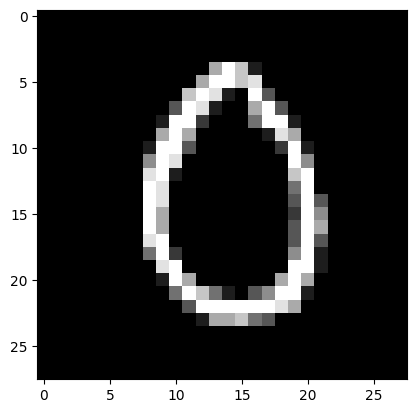

tensor([1, 9, 4, 5, 4, 7, 5, 7, 6, 2, 2, 4, 7, 6, 9, 4, 2, 4, 9, 7, 2, 1, 7, 8,
        9, 8, 1, 1, 0, 8, 8, 9, 5, 4, 1, 6, 5, 0, 7, 9, 3, 5, 6, 5, 1, 9, 2, 4,
        7, 8, 3, 2, 9, 6, 8, 0, 9, 3, 8, 3, 5, 3, 8, 5])
Imagenes:  torch.Size([28, 28])


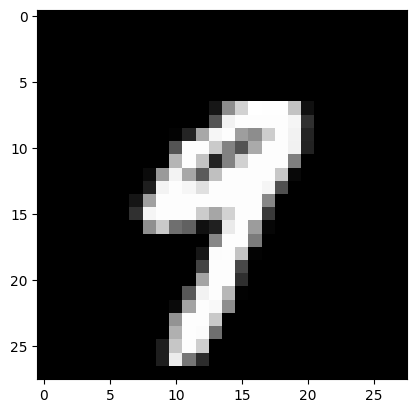

In [10]:
for i in range(0,2):
  j, k = train_loader.__iter__().__next__()
  imagen = j[i][0]
  print(k)
  print("Imagenes: ",imagen.shape)
  plt.imshow(imagen, cmap='gray')
  plt.show()

In [11]:
sample_img, _ = train_loader.__iter__().__next__()
one_img = sample_img[0][0]
sample_img[0].shape

torch.Size([1, 28, 28])

### Patch Extraction

#### Neural Network / CNN / Backbone

In [12]:
#Copied from the file CNNPytorch
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84) # We want this output, there fore we will remove the next line
        self.fc3 = nn.Linear(84, 10)

        #self.concept_layer = nn.Linear(84, n_concepts)
        #self.reasoning = nn.Linear(n_concepts, n_classes, bias=False)

        self.misclassified = []  # list to store wrong images predictions

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        features = F.relu(self.fc2(x))

        #concepts = torch.sigmoid(self.concept_layer(features))
        #logits = self.reasoning(concepts)

        x = self.fc3(features)
        #return logits, concepts
        return x

class FeatureExtractor(nn.Module):  # This is 'g' - The model without the head
    def __init__(self, base_model):
        super().__init__()
        self.conv1 = base_model.conv1
        self.conv2 = base_model.conv2
        self.pool = base_model.pool


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

class Classifier(nn.Module):  # This is 'h' - the head with 10 classes
    def __init__(self, base_model):
        super().__init__()
        self.fc1 = base_model.fc1
        self.fc2 = base_model.fc2
        self.fc3 = base_model.fc3

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#backbone = Net().to(device)
#backbone.load_state_dict(torch.load('mnist_cnnPytorch.pt'), strict=False)

In [13]:
# Charge the trained model
backbone = Net()
backbone.load_state_dict(torch.load('mnist_cnnPytorch.pt'))
backbone.eval()

g = FeatureExtractor(backbone).to(device) #  Output: [batch,filters,h_size,w_size] ~ [64,64,5,5]
h = Classifier(backbone).to(device) # Head of the model

In [ ]:
print("Extracting patches for discovery...")

# Stratified sampling: 50 images per class
class_indices = [[] for _ in range(10)]
for idx in range(len(train_ds)):
    _, label = train_ds[idx]
    class_indices[label].append(idx)

samples_per_class = 50
stratified_indices = []
for class_label in range(10):
    stratified_indices.extend(class_indices[class_label][:samples_per_class])

train_subset = torch.utils.data.Subset(train_ds, stratified_indices)


images_list = []
for idx in range(len(train_subset)):
    img, _ = train_subset[idx]  # img is already a tensor from transforms.ToTensor()
    images_list.append(img)

# Stack all images into a single tensor
images_preprocessed = torch.stack(images_list).to(device)

print(f"images_preprocessed shape: {images_preprocessed.shape}")


Extracting patches for discovery...
images_preprocessed shape: torch.Size([500, 1, 28, 28])


In [14]:
patch_size = 7
stride = 7
n_concepts = 15 #15-20
layer_name = "fc2" #is from we get the features

In [15]:
from craft.craft_torch import Craft, torch_to_numpy

""""""
# Prepare images
images_list = []
for idx in range(len(train_subset)):
    img, _ = train_subset[idx]
    images_list.append(img)
images_preprocessed = torch.stack(images_list).to(device)

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = n_concepts,
              patch_size = patch_size,
              batch_size = 64,
              device = device)


# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
#
#Apparently , we don't use crops in UCBM
crops, crops_u, w = craft.fit(images_preprocessed)
crops = np.moveaxis(torch_to_numpy(crops), 1, -1)


print(crops.shape, crops_u.shape, w.shape)

# w, from CRAFT has a shape of [n_features, n_concepts]
#OPTIONAL

# Save the concept bank (W matrix from NMF)
np.save("craft_concept_bank.npy", w)


# Load later
# https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/discover_concepts.py#L108C80-L108C94
# The concepts are saved in a file "h.npy"
# The train function uses the concept bank: https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/train_cbm.py#L44

#try:
 # w = np.load("craft_concept_bank.npy") #this is the h.py
  #print("Concepts loaded")
#except NameError:
 # print("No Concepts file found", NameError)


NameError: name 'train_subset' is not defined

# First Try

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MNIST_UCBM(nn.Module):
    def __init__(self, backbone_g, concept_bank, n_classes=10):
        super().__init__()
        self.backbone_g = backbone_g # FeatureExtractor(backbone)

        # Convert the numpy concept bank (W) to a PyTorch tensor
        # W shape from CRAFT: (n_concepts, n_features)
        self.W = nn.Parameter(torch.from_numpy(concept_bank).float(), requires_grad=False)
        self.n_concepts = self.W.shape[0]

        # This is the "Reasoning Layer" - the only part we need to train
        # It maps 10 or 15 or 20 concepts -> 10 classes
        self.classifier = nn.Linear(self.n_concepts, n_classes, bias=True)

    def forward(self, x):
        # 1. Extract spatial features: [batch, 64, 5, 5]
        features = self.backbone_g(x)
        batch_size, channels, h_size, w_size = features.shape

        # 2. Flatten spatial features for projection: [batch * 5 * 5, 64]
        features_flat = features.permute(0, 2, 3, 1).reshape(-1, channels)

        # 3. Project features onto Concept Bank (Dot product)
        # This gives the intensity of each concept at every spatial location
        # [batch * 5 * 5, n_concepts]
        concept_spatial = torch.matmul(features_flat, self.W.t())

        # 4. Global Average Pooling over spatial dimensions to get image-level concept scores
        # [batch, 5, 5, n_concepts] -> [batch, n_concepts]
        concept_scores = concept_spatial.view(batch_size, h_size, w_size, self.n_concepts)
        concept_vector = torch.mean(concept_scores, dim=(1, 2))

        # 5. Final classification
        logits = self.classifier(concept_vector)

        return logits, concept_vector

In [ ]:
# Initialize UCBM
ucbm_model = MNIST_UCBM(g, w).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize the classifier parameters
optimizer = torch.optim.Adam(ucbm_model.classifier.parameters(), lr=0.003)

def train_ucbm(model, loader, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, concepts = model(images)
            loss = criterion(logits, labels)

            # Optional: Add L1 regularization on concepts for sparsity (common in UCBM)
            l1_loss = 1e-4 * torch.norm(concepts, 1)
            loss += l1_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = logits.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

        print(f"Epoch {epoch+1}: Loss: {total_loss/len(loader):.4f}, Acc: {100. * correct / len(loader.dataset):.2f}%")

train_ucbm(ucbm_model, train_loader)

Epoch 1: Loss: 2.0577, Acc: 42.81%
Epoch 2: Loss: 1.6828, Acc: 58.80%
Epoch 3: Loss: 1.5488, Acc: 65.23%
Epoch 4: Loss: 1.4634, Acc: 68.84%
Epoch 5: Loss: 1.4030, Acc: 71.30%
Epoch 6: Loss: 1.3576, Acc: 72.92%
Epoch 7: Loss: 1.3183, Acc: 74.40%
Epoch 8: Loss: 1.2880, Acc: 75.43%
Epoch 9: Loss: 1.2631, Acc: 76.06%
Epoch 10: Loss: 1.2415, Acc: 76.50%
Epoch 11: Loss: 1.2230, Acc: 77.27%
Epoch 12: Loss: 1.2083, Acc: 77.55%
Epoch 13: Loss: 1.1924, Acc: 78.12%
Epoch 14: Loss: 1.1797, Acc: 78.45%
Epoch 15: Loss: 1.1682, Acc: 78.80%
Epoch 16: Loss: 1.1600, Acc: 78.90%
Epoch 17: Loss: 1.1497, Acc: 79.18%
Epoch 18: Loss: 1.1410, Acc: 79.46%
Epoch 19: Loss: 1.1330, Acc: 79.60%
Epoch 20: Loss: 1.1262, Acc: 79.86%
Epoch 21: Loss: 1.1191, Acc: 79.91%
Epoch 22: Loss: 1.1133, Acc: 80.17%
Epoch 23: Loss: 1.1075, Acc: 80.33%
Epoch 24: Loss: 1.1021, Acc: 80.44%
Epoch 25: Loss: 1.0978, Acc: 80.35%
Epoch 26: Loss: 1.0934, Acc: 80.62%
Epoch 27: Loss: 1.0882, Acc: 80.72%
Epoch 28: Loss: 1.0836, Acc: 80.88%
E

In [ ]:
torch.save(ucbm_model.state_dict(), "ucbm_model.pth")

In [ ]:
def test_ucbm(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits, _ = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100. * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

test_ucbm(ucbm_model, test_loader)

Test Accuracy: 79.87%


79.87142857142857

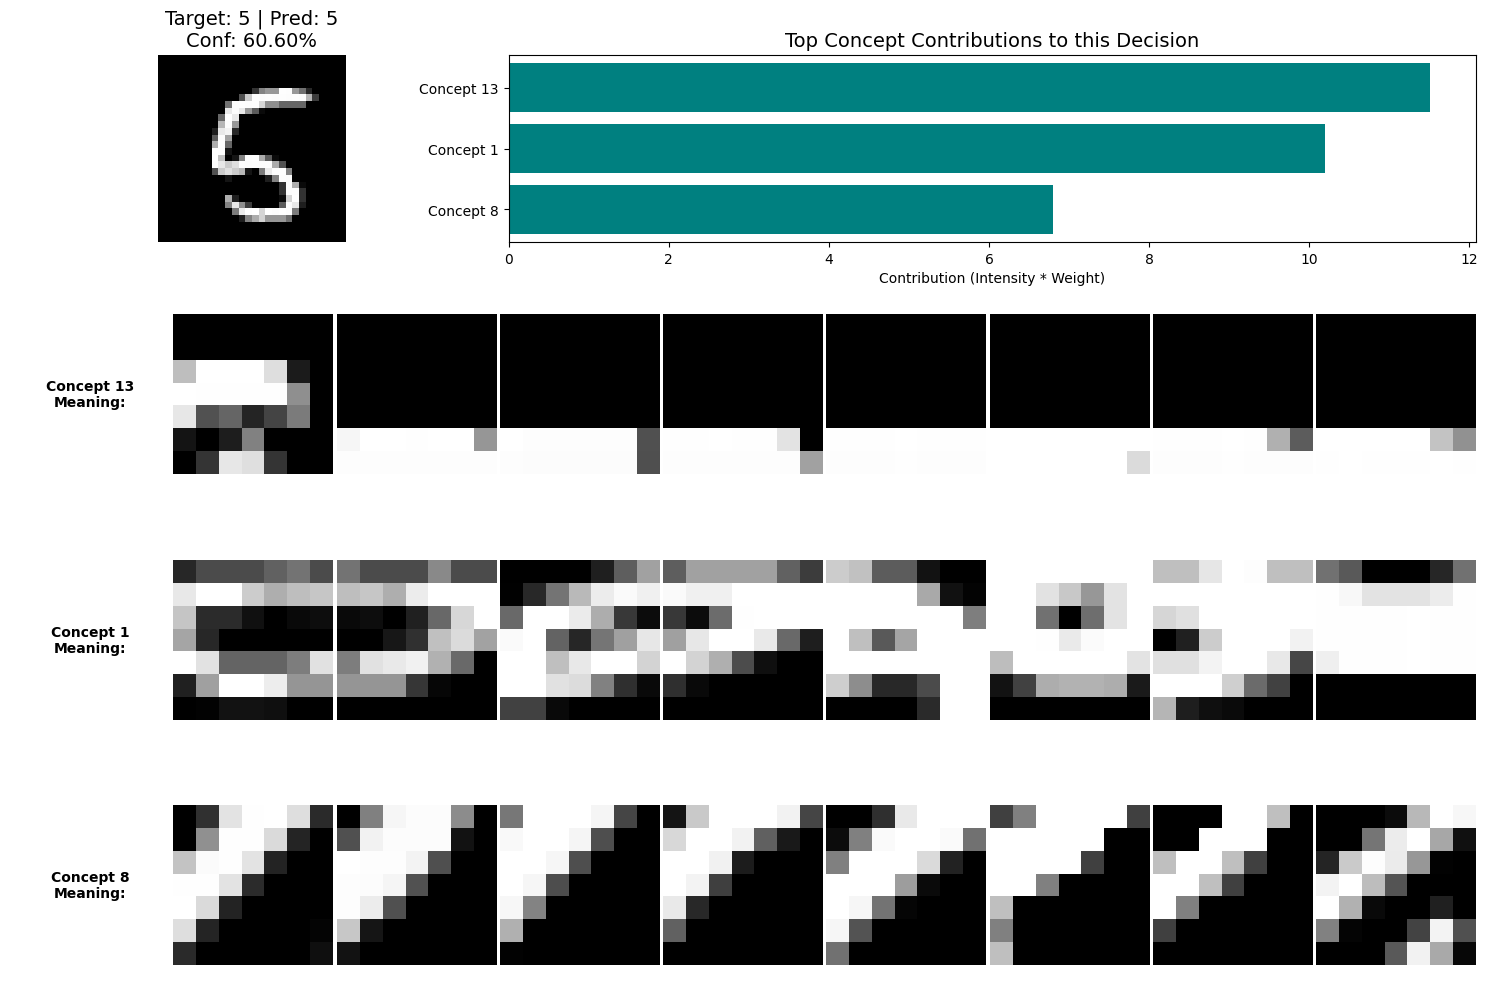

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2

def display_ucbm_dashboard(model, image_tensor, label, crops, crops_u, k=5):
    """
    Displays a comprehensive dashboard:
    1. Original Image & Prediction
    2. Top-K Concepts contributing to the decision
    3. Visual galleries for each of those Top-K concepts
    """
    model.eval()
    with torch.no_grad():
        # 1. Forward pass
        img_input = image_tensor.unsqueeze(0).to(device)
        logits, concept_vector = model(img_input)

        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs).item()

        # 2. Extract Reasoning
        # Concept contribution = (Concept Intensity) * (Classifier Weight for predicted class)
        concept_intensities = concept_vector[0].cpu().numpy()
        reasoning_weights = model.classifier.weight[pred_class].cpu().numpy()
        contributions = concept_intensities * reasoning_weights

        # 3. Find Top-K Concepts by contribution
        top_k_indices = np.argsort(contributions)[::-1][:k]

    # --- PLOTTING ---
    # We create a grid: Top row for the Image & Bar Chart,
    # then one row per Top-K concept for their galleries.
    fig = plt.figure(figsize=(15, 4 + (2 * k)))
    gs = fig.add_gridspec(k + 1, 2, width_ratios=[1, 2])

    # A. Original Image
    ax_img = fig.add_subplot(gs[0, 0])
    img_display = image_tensor.squeeze().cpu().numpy()
    ax_img.imshow(img_display, cmap='gray')
    ax_img.set_title(f"Target: {label} | Pred: {pred_class}\nConf: {probs[0, pred_class]:.2%}", fontsize=14)
    ax_img.axis('off')

    # B. Contribution Bar Chart
    ax_bar = fig.add_subplot(gs[0, 1])
    y_pos = np.arange(k)
    ax_bar.barh(y_pos, contributions[top_k_indices], color='teal')
    ax_bar.set_yticks(y_pos)
    ax_bar.set_yticklabels([f"Concept {i}" for i in top_k_indices])
    ax_bar.invert_yaxis()
    ax_bar.set_title("Top Concept Contributions to this Decision", fontsize=14)
    ax_bar.set_xlabel("Contribution (Intensity * Weight)")

    # C. Concept Galleries
    for i, c_idx in enumerate(top_k_indices):
        # Find 8 best patches for this concept from the saved CRAFT data
        best_patch_ids = np.argsort(crops_u[:, c_idx])[::-1][:8]
        best_patches = crops[best_patch_ids]

        # Create a sub-grid for this row's gallery
        inner_gs = gs[i+1, :].subgridspec(1, 9)

        # Label for the row
        ax_label = fig.add_subplot(inner_gs[0, 0])
        ax_label.text(0.5, 0.5, f"Concept {c_idx}\nMeaning:", ha='center', va='center', fontweight='bold')
        ax_label.axis('off')

        for j in range(8):
            ax_patch = fig.add_subplot(inner_gs[0, j+1])
            patch = best_patches[j]
            if patch.shape[0] == 1: patch = patch.squeeze(0)
            ax_patch.imshow(patch, cmap='gray')
            ax_patch.axis('off')

    plt.tight_layout()
    plt.show()

# --- RUN DASHBOARD ---
# Pick an image (e.g., index 0 of test set)
test_img, test_label = test_ds[8]
display_ucbm_dashboard(ucbm_model, test_img, test_label, crops, crops_u, k=3)

# UCBM

In [16]:
#https://github.com/lmb-freiburg/ucbm/blob/main/concept_auxiliaries/concept_auxiliaries.py

from typing import Optional, Literal, Union, Callable
from os import path, listdir, makedirs
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm, trange
import math
import tempfile
import shutil


# Class implementing a dataset, that is loading single tensors from files
# in a given directory in alphabetic order.
class MemTensorDataset(Dataset):
    def __init__(self, root: str, normalize=False, mean: Optional[torch.Tensor] = None, std: Optional[torch.Tensor] = None):
        self.root = root
        self.normalize = normalize
        if root[-1] == "/":
            root = root[:-1]
        last_dir = root.split("/")[-1]
        self.samples = [f for f in listdir(root) if f.endswith(".pth") and "activations" in f]
        def key(x: str) -> int:
            x = x.removeprefix(last_dir + "_")
            x = x.removesuffix(".pth")
            return int(x)
        self.samples.sort(key=key)
        if self.normalize:
            if mean is None or std is None:
                if not path.exists(path.join(root, "mean.pt")) or not path.exists(path.join(root, "std.pt")):
                    batch_size = 64
                    size = torch.load(path.join(self.root, self.samples[0])).size()
                    mean = torch.zeros(size)
                    meansq = torch.zeros(size)
                    for i in trange(math.ceil(len(self) / batch_size), leave=False):
                        start = i * batch_size
                        end = (i+1) * batch_size
                        if end > len(self):
                            end = len(self)
                        batch = torch.stack(
                            [torch.load(path.join(self.root, sam))
                            for sam in self.samples[start:end]])
                        mean += torch.sum(batch, dim=0)
                        meansq += torch.sum(batch**2, dim=0)
                    mean = mean / len(self)
                    meansq = meansq / len(self)
                    std = torch.sqrt(meansq - mean**2)
                    if torch.any(torch.isnan(std)):
                        diff = meansq - mean**2
                        std = torch.sqrt(torch.clamp(diff, min=diff[diff>0].min()))
                    assert not torch.any(torch.isnan(mean))
                    torch.save(mean, path.join(root, "mean.pt"))
                    assert not torch.any(torch.isnan(std))
                    torch.save(std, path.join(root, "std.pt"))
                else:
                    mean = torch.load(path.join(path.join(root, "mean.pt")))
                    std = torch.load(path.join(path.join(root, "std.pt")))
            self.mean = mean
            self.std = std


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        tens = torch.load(path.join(self.root, self.samples[idx]))
        if self.normalize:
            tens = (tens - self.mean)  / self.std
        return tens


@torch.no_grad()
def raw_concept_sims(h: Union[np.ndarray, torch.Tensor],
                     dataset: Dataset,
                     backbone: Union[nn.Module, Callable],
                     batch_size: int,
                     device: Literal['cuda', 'cpu'],
                     saved_activation_path: Optional[str] = None,
                     data_label: Optional[str] = None,
                     normalize=False,
                     mean=None,
                     std=None) \
                        -> Dataset[torch.Tensor]:
    '''
    Compute raw concept similarities using cosine similarity.

    Parameters
    ----------
    h: np.ndarray
        Concept vectors in shape (#concepts, p).
    dataset: Dataset
        The dataset to compute the concept similarities on.
    backbone: nn.Module | Callable
        The model backbone.
    batch_size: int
        The batch_size in which the concept similarities are computed.
    device: Literal['cuda', 'cpu']
        The device to compute the similarities on.
    saved_activation_path: Optional[str] = None
        The folder where the activations of the current dataset and
        backbone can be/are saved.
    data_label: Optional[str] = None
        The data_label (train or test) for the dataset to identify the
        correct pre_computed concept similarities.
    normalize: bool = False
        Wheter to normalize the concept similarities concept-wise. If mean and
        std is given, these values are used, otherwise mean and std will be
        computed on the given dataset.
    mean: Optional[torch.Tensor] = None
    std: Optional[torch.Tensor] = None

    Returns
    -------
    sim: Dataset[torch.Tensor]
        Dataset containing the concept similarities of each image in
        given dataset (in the same order).


    assert ((saved_activation_path is None and data_label is None) or
            (saved_activation_path is not None and data_label is not None)), \
            "saved_activation_path and data_label must be both None or not None. "

    save = data_label is not None
    if not save:
        saved_activation_path = tempfile.gettempdir()
        data_label = "tmp"

    # Check if file with activations already exists.
    # If so, read them from the file.
    largest_index = None
    if save:
        save_name = f"saved_{data_label}_activations"
        saving_dir = path.join(saved_activation_path, save_name)

        if path.exists(saving_dir) and len([f for f in listdir(saving_dir) if "activations" in f]) == len(dataset):
            return MemTensorDataset(saving_dir, normalize=normalize, mean=mean, std=std)
        elif not path.exists(saving_dir):
            makedirs(saving_dir, exist_ok=True)
        else:
            if len(listdir(saving_dir)) == 0:
                largest_index = -1
            else:
                largest_index = max(int(file.split(".")[0].removeprefix(f"{save_name}_")) for file in listdir(saving_dir) if "activations" in file)
    else:
        save_name = f"saved_{data_label}_activations"
        saving_dir = path.join(saved_activation_path, save_name)

        if path.exists(saving_dir):
            shutil.rmtree(saving_dir)
        makedirs(saving_dir)
        largest_index = -1
    '''

    save = data_label is not None
    if save:
        folder_name = f"saved_{data_label}_activations"
        saving_dir = path.join(saved_activation_path, folder_name)
        os.makedirs(saving_dir, exist_ok=True)
        save_name = folder_name

    else:
        saving_dir = None
        save_name = None

    largest_index = -1
    #saving_dir = "UCBM"
    #save_name = "UCBM"

    # Calculate the concept similarities.
    all_activations = []


    # Convert CAVs to normalized tensor.
    h = h if torch.is_tensor(h) else torch.tensor(h)
    h = h.to(device)
    h /= torch.norm(h, dim=1, keepdim=True)

    # Load the data from dataset.
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # If activations are not saved to file, collect them in variable.

    if isinstance(backbone, nn.Module):
        backbone.to(device)
        backbone.eval()

    # Compute concept similarities.
    for i, (X_batch, _) in enumerate(tqdm(data_loader, leave=False)):
        if largest_index is not None and (i + 1) * batch_size - 1 < largest_index:
            continue
        out = backbone(X_batch.to(device))

        if len(out.shape) == 4:
            out = torch.mean(out, dim=(2, 3))

        out = out / torch.norm(out, dim=1, keepdim=True)
        out = out.type(h.dtype)

        out = torch.matmul(out, h.T)

        out = out.cpu()
        all_activations.append(out)
        if save: # Ensure you have this flag from your outer function
                # Name the file using the batch index 'i'
          batch_file = path.join(saving_dir, f"{save_name}_{i}.pt")
          torch.save(out, batch_file)
        #The next comented code is necessary just when the dataset is huge, we can keep the activations in RAM thanks to the size of MNIST

        #width = out.shape[0]
        #for j in range(width):
        #    f_name = path.join(
        #        saving_dir, f"{save_name}_{i*batch_size+j}.pth")
        #    torch.save(torch.from_numpy(out[j,:].numpy()), f_name)

    #return MemTensorDataset(saving_dir, normalize=normalize, mean=mean, std=std)
    return torch.cat(all_activations)

In [17]:
#https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/data_loader.py#L9
def load_data(subset, parent_dataset):
    if isinstance(parent_dataset, torch.utils.data.ConcatDataset):
        subset.classes = parent_dataset.datasets[0].classes
        all_targets = torch.cat([d.targets for d in parent_dataset.datasets])
    else:
        subset.classes = parent_dataset.classes
        all_targets = parent_dataset.targets
    subset.targets = all_targets[subset.indices]
    return subset

train_data = load_data(train_ds, full_dataset)
val_data   = load_data(val_ds, full_dataset)
test_data  = load_data(test_ds, full_dataset)

In [18]:
def raw_concept_sims_RAM(dataset, backbone, h, device):
    loader = DataLoader(dataset, batch_size=64)
    all_activations = []

    backbone.eval()
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            # Project: (Batch x Features) @ (Concepts x Features).T
            feats = backbone(data).flatten(1)
            # Normalize and Project
            feats = feats / feats.norm(dim=1, keepdim=True)
            acts = torch.matmul(feats, h.T)
            all_activations.append(acts.cpu())

    return torch.cat(all_activations) # Returns one big tensor [N_images, N_concepts]

In [19]:
class PDataset(Dataset):
    def __init__(self, *its, list_to_tensor: bool = True):
        # We use *its to accept any number of inputs (embeddings, targets, etc.) [cite: 31]
        assert len(its) > 0, "At least one sequence must be given"

        # Verify all sequences are the same length [cite: 31]
        first_len = self.get_length(its[0])
        assert all(first_len == self.get_length(it) for it in its), \
            "Provided iterables needs to be from same size."

        self.its = its
        self.list_to_tensor = list_to_tensor

    def get_length(self, it):
        if hasattr(it, '__len__'):
            return len(it)
        if torch.is_tensor(it):
            return it.shape[0]
        return len(it)

    def __len__(self):
        return self.get_length(self.its[0])

    def __getitem__(self, idx):
        res = []
        for it in self.its:
            item = it[idx]

            # If item is a list/numpy and flag is true, convert to tensor [cite: 31]
            if self.list_to_tensor:
                if isinstance(item, (list, np.ndarray)):
                    item = torch.tensor(item)
                elif not torch.is_tensor(item):
                    # Convert scalars (like targets) to tensors
                    item = torch.tensor(item)

            res.append(item)
        return res # Returns [embedding, target] [cite: 31]

Tarea: Reducir el codigo

In [20]:
from typing import Literal, Union, Optional, Callable
import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from scipy.special import softmax
from sklearn.metrics import roc_auc_score
from copy import deepcopy

from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torcheval.metrics.functional import multilabel_accuracy, multiclass_accuracy, multiclass_auprc, multilabel_auprc, binary_auroc, multiclass_auroc, binary_auprc


################################################################################
#                                                                              #
#                                  LeakyReLU                                   #
#         ReLU-similar function, which is not killing the gradient.            #
#                                                                              #
################################################################################
class LeakyReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.neg = x < 0
        return x.clamp(min=0.0)

    @staticmethod
    def backward(self, grad_output: torch.Tensor):
        grad_input = grad_output.clone()
        grad_input[self.neg] *= 0.1
        return grad_input

################################################################################
#                                                                              #
#                                   JumpReLU                                   #
#                 JumpReLU with straight-through estimator.                    #
#                Following: https://arxiv.org/abs/2407.14435                   #
#                                                                              #
################################################################################

class RectangleFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return ((x > -0.5) & (x < 0.5)).to(x.dtype)

    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[(x <= -0.5) | (x >= 0.5)] = 0
        return grad_input

def rectangle(x: torch.Tensor) -> torch.Tensor:
    return RectangleFunction.apply(x)

class _JumpReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx,
                x: torch.Tensor,
                threshold: torch.Tensor,
                bandwidth: float) -> torch.Tensor:
        ctx.save_for_backward(x, threshold)
        ctx.bandwidth = bandwidth
        return x * (x > threshold).to(x.dtype)

    @staticmethod
    def backward(ctx, output_grad: torch.Tensor): # ste
        x, threshold = ctx.saved_tensors
        bandwidth = ctx.bandwidth
        x_grad = (x > threshold).to(x.dtype) * output_grad
        rect_value = rectangle((x - threshold) / bandwidth)
        threshold_grad = -(threshold / bandwidth) * rect_value * output_grad
        return x_grad, threshold_grad, None

class JumpReLU(nn.Module):
    def __init__(self,
                 num_concepts: int,
                 threshold_init: Optional[torch.Tensor] = None,
                 bandwidth: float = 1e-3):
        super(JumpReLU, self).__init__()
        self.log_threshold = nn.Parameter(-10*torch.ones(num_concepts,
                                                         requires_grad=True))
        if threshold_init is not None:
            assert threshold_init.numel() == num_concepts, \
                f"Init threshold is of dimension {threshold_init.size()}" + \
                f", but should be of dimension {num_concepts}. "
            self.log_threshold = threshold_init
        self.bandwidth = bandwidth

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return _JumpReLU.apply(
            x,
            self.log_threshold.exp(),  # exp ensures positive threshold
            self.bandwidth
            )

################################################################################
#                                                                              #
#                                    L0-Loss                                   #
#           L0-similar function which is not killing the gradient.             #
#                                                                              #
################################################################################

class _StepFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx,
                x: torch.Tensor,
                threshold: torch.Tensor,
                bandwidth: float) -> torch.Tensor:
        ctx.save_for_backward(x, threshold)
        ctx.bandwidth = bandwidth
        return (x > threshold).to(x.dtype)

    @staticmethod
    def backward(ctx, output_grad: torch.Tensor): # ste
        x, threshold = ctx.saved_tensors
        bandwidth = ctx.bandwidth
        x_grad = torch.zeros_like(x)
        rect_value = rectangle((x - threshold) / bandwidth)
        threshold_grad = -(1.0 / bandwidth) * rect_value * output_grad
        return x_grad, threshold_grad, None

class StepFunction(nn.Module):
    def __init__(self):
        super(StepFunction, self).__init__()

    def forward(self,
                x: torch.Tensor,
                threshold: torch.Tensor,
                bandwidth: float) -> torch.Tensor:
        return _StepFunction.apply(x, threshold, bandwidth)

step_function = StepFunction()
def l0_loss(x: torch.Tensor,
            threshold: torch.Tensor,
            bandwidth: float) -> torch.Tensor:
    out = step_function(x, threshold, bandwidth)
    return torch.sum(out, dim=-1).sum()


def l0_approx(x: torch.Tensor,
              threshold: torch.Tensor,
              a: int = 20) -> float:
    out = 1 / (1 + torch.exp(-a*(x - threshold)))
    return out.sum().item()

################################################################################
#                                                                              #
#                                 Elastic-Loss                                 #
#                                                                              #
################################################################################

def elastic_loss(weight_or_act: torch.Tensor,
                 alpha: float = 0.99) -> torch.Tensor:
    l1 = weight_or_act.norm(p=1)
    l2 = (weight_or_act**2).sum()
    return 0.5 * (1 - alpha) * l2 + alpha * l1

def elastic_loss_weights(weight: torch.Tensor,
                         alpha: float = 0.99) -> torch.Tensor:
    l1 = weight.norm(p=1)
    l2 = (weight**2).sum()
    return 0.5 * (1 - alpha) * l2 + alpha * l1

def elastic_loss_activations(act: torch.Tensor,
                             alpha: float = 0.99) -> torch.Tensor:
    l1 = act.norm(p=1, dim=-1)
    l2 = (act**2).sum(dim=-1)
    return torch.sum(0.5 * (1 - alpha) * l2 + alpha * l1)


################################################################################
#                                                                              #
#                                 TopK-Module                                  #
#                  Module that keeps only k largest values.                    #
#      Implementation from  https://github.com/openai/sparse_autoencoder
      #
################################################################################

class TopK(nn.Module):
    def __init__(self,
                 k: int,
                 postact_fn: Callable = nn.ReLU()):
        super().__init__()
        self.k = k
        self.postact_fn = postact_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        topk = torch.topk(x, k=self.k, dim=-1)
        values = self.postact_fn(topk.values)
        # make all other values 0
        result = torch.zeros_like(x)
        result.scatter_(-1, topk.indices, values)
        return result

    def state_dict(self, destination=None, prefix="", keep_vars=False):
        state_dict = super().state_dict(destination, prefix, keep_vars)
        state_dict.update(
            {prefix + "k": self.k,
             prefix + "postact_fn": self.postact_fn.__class__.__name__})
        return state_dict

    @classmethod
    def from_state_dict(cls,
                        state_dict: dict[str, torch.Tensor],
                        strict: bool = True) -> "TopK":
        k = state_dict["k"]
        postact_fn = ACTIVATIONS_CLASSES[state_dict["postact_fn"]]()
        return cls(k=k, postact_fn=postact_fn)

ACTIVATIONS_CLASSES = {
    "ReLU": nn.ReLU,
    "Identity": nn.Identity,
    "TopK": TopK,
}


################################################################################
#                                                                              #
#                                  Classifier                                  #
#             Interpretable classifier from concepts to classes.               #
#                                                                              #
################################################################################

class Classifier(nn.Module):
    def __init__(self,
                 num_concepts: int,
                 num_classes: int,
                 relu: Literal["no", "ReLU", "jumpReLU"] = "ReLU",
                 scale: Literal["learn", "no"] = "no",
                 bias: Literal["learn", "no"] = "no",
                 dropout_p: float = 0,
                 k: int = -1,
                 jumpReLU_threshold_init: Optional[torch.Tensor] = None):
        '''
        Interpretable (linear) classifier from concept space to
        classification space.

        num_concepts: int
            number of concepts in concept space
        num_classes: int
            number of classes in classification space
        relu: Literal["no", "ReLU", "jumpReLU"] = "ReLU"
            relu function to use after gating
        scale: Literal["learn", "no"] = "no"
            scale to scale the cosine similarities,
            set "learn" to learn scale and "no" to disable
        bias: Literal["learn", "no"] = "no"
            bias to substract from scaled cosine similarities
            set "learn" to learn bias and "no" to disable
        dropout_p: float = 0
            dropout rate from concept dropout
        k: int = -1
            If k >= 0 TopK is used instead of gating, else nothing happens
        jumpReLU_threshold_init: Optional[torch.Tensor] = None
            Init value of jumpReLU
        '''
        super().__init__()
        self.relu = relu
        if relu == "jumpReLU":
            self._jumpReLU = JumpReLU(num_concepts, jumpReLU_threshold_init)
        self.scale_method = scale
        self.bias_method = bias
        self.dropout = (dropout_p > 0)
        self.dropout_layer = nn.Dropout(p=dropout_p)
        self.k = k
        if self.k >= 0:
            self.top_k = TopK(self.k)
        if self.scale_method == "learn":
            self.log_scaling = nn.Parameter(
                torch.zeros(num_concepts, requires_grad=True))
        if self.bias_method == "learn":
            self.log_offset = nn.Parameter(-10*torch.ones(num_concepts, requires_grad=True))

        self.linear = nn.Linear(num_concepts, num_classes)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # input-dependent concept selection
        if self.scale_method == "learn":
            x = self.log_scaling.exp() * x  # exp ensures positive scale

        if self.bias_method == "learn":
            x = x - self.log_offset.exp()  # exp ensures positive bias

        if self.relu == "ReLU":
            gated = F.relu(x)
        elif self.relu == "jumpReLU":
            gated = self._jumpReLU(x)
        elif self.k >= 0:
            gated = self.top_k(x)
        elif self.relu == "no":
            gated = x
        else:
            raise NotImplementedError

        # concept dropout
        if self.dropout:
            mask = torch.ones_like(gated)
            mask = self.dropout_layer(mask)
            gated = gated * mask
            x = x * mask

        # sparse linear layer
        out = self.linear(gated)
        return out, gated, x


################################################################################
#                                                                              #
#                                     UCBM                                     #
#                    unsupervised concept bottleneck model                     #
#                                                                              #
################################################################################
class UCBM:
    def __init__(self,
                 backbone,
                 h: Union [torch.Tensor, np.ndarray],
                 batch_size: int,
                 epochs: int,
                 lam_gate: float,
                 lam_w: float,
                 dropout_p: float,
                 learning_rate: float,
                 relu: Literal["no", "ReLU", "jumpReLU"],
                 scale_mode: Literal['learn', 'no'],
                 bias_mode: Literal['learn', 'no'],
                 normalize: bool,
                 k: int,
                 device: Literal['cuda', 'cpu']):

        self._backbone = backbone # we have it, FeatureExtractor
        if not torch.is_tensor(h):
            h = torch.tensor(h) # h is the concepts
        self._num_concepts = h.shape[0]  #shape (10, 64)
        self._h = h.to(device)
        self._h = self._h / torch.norm(self._h, dim=1, keepdim=True) #Normalize the concepts
        self._batch_size = batch_size #we have it from the DataLoader = 64
        self._lr = learning_rate # we have it
        self._device = device #GPU. Thanks google
        self._epochs = epochs # we can personalize it
        self._lam_gate = lam_gate # The autor says lam_gate =  0
        self._lam_w = lam_w #The author set lam_w = 8e-4
        self._dropout_p = dropout_p # The author fit dropout_p = 0.2
        self._relu = relu # The author says = "no" but could be "ReLU" or "jumpReLU"
        self._scale_mode = scale_mode # Author says scale_choose= 'no'
        self._bias_mode = bias_mode # Author says bias_choose='learn'
        self._normalize = normalize # Author says _get_concept_embeddings(normalize_concepts = False)
        self._k = k # The author says k = 66 but we will chose 3 or 5

    @torch.no_grad()
    def _get_concept_embeddings(self,
                                dataset: Dataset,
                                saved_activation_path: Optional[str] = None,
                                data_label: Optional[str] = None,
                                normalize=False,
                                mean=None,
                                std=None) \
                                    -> Dataset[torch.Tensor]:


        return raw_concept_sims(self._h,
                                dataset,
                                self._backbone,
                                self._batch_size,
                                self._device,
                                saved_activation_path,
                                data_label,
                                normalize=normalize,
                                mean=mean,
                                std=std)

    def fit(self,
            training_set: ImageFolder,
            saved_activation_path: str,
            test_set: Optional[ImageFolder] = None,
            verbose: bool = True,
            cocostuff_training: bool = False):

        # Load the concept activations.
        embeddings = self._get_concept_embeddings(
            training_set,
            saved_activation_path,
            "train",
            normalize=self._normalize,
            mean=None,
            std=None)
        self._mean = embeddings.mean if self._normalize else None
        self._std = embeddings.std if self._normalize else None

        if verbose:
            print("Loaded concept activations of training dataset...")

        # Function that returns the indexes of a sequence, that are label
        # with the given class_id.
        def indices_tensor(targets, class_id):
            return (torch.Tensor(targets) == class_id).nonzero().reshape(-1)

        # Load scale and bias values.
        self._num_classes = 10
        self._multilabel = False #isinstance(training_set.targets[0], list) #False. This tells the model to use CrossEntropyLoss (pick one winner) instead of BCEWithLogitsLoss

        # Load the model.
        self._classifier = Classifier(
            self._num_concepts, #Search the line self._num_concepts = h.shape[0]  #shape (10, 64) = 10
            self._num_classes,  # MNIST = 10
            self._relu, # Search the line above
            self._scale_mode, #Search the line above
            self._bias_mode, #Search the line above
            self._dropout_p, #Search the line above
            self._k) #Search the line above

        self._classifier = self._classifier.to(self._device) #Ready

        # Load stuff required for training the model, stuff that don't recive MNIST or CRAFT inputs.
        loss_fn = nn.BCEWithLogitsLoss() if self._multilabel else nn.CrossEntropyLoss()
        optimizer = optim.Adam(self._classifier.parameters(), lr=self._lr)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=self._epochs)

        # Load data // I think we won't need this for now
        dset = PDataset(embeddings, training_set.targets)  #(embeddings = self._get_concept_embeddings, MNIST Dataset )

        """
        if isinstance(training_set, Subset):
            parent_ds = training_set.dataset
            indices = training_set.indices
        else:
            parent_ds = training_set
            indices = None
        if isinstance(parent_ds, ConcatDataset):
          # Stack the targets from MNIST Train and MNIST Test
          # MNIST targets are tensors, so we use torch.cat
          all_targets = torch.cat([ds.targets for ds in parent_ds.datasets])
        else:
            all_targets = parent_ds.targets

        if indices is not None:
        # Use the indices to pick the correct answers
            subset_targets = all_targets[indices]
        else:
            subset_targets = all_targets

        dset = TensorDataset(embeddings.cpu(), subset_targets.cpu())
        """
        data_loader = DataLoader(dset, self._batch_size, shuffle=True, num_workers=4)

        # Train the model
        for i in trange(self._epochs, leave=False):
            self._classifier.train()
            corr, n_samples = 0, 0
            #if self._relu == "jumpReLU":
                #print(self._classifier._jumpReLU.log_threshold.exp().mean())
                #print(self._classifier._jumpReLU.log_threshold.mean())
            for X_batch, y_batch in tqdm(data_loader, leave=False):
                y_batch = y_batch.to(self._device)
                out = X_batch.to(self._device)

                # Train the model.
                optimizer.zero_grad()
                y_pred, after_gate, before_gate = self._classifier(out)
                loss = loss_fn(y_pred, y_batch)

                # gate sparsity penalty
                if self._lam_gate != 0:
                    if self._relu != "jumpReLU":
                        loss += self._lam_gate * elastic_loss_activations(after_gate)
                    else:
                        loss += self._lam_gate * l0_loss(before_gate, self._classifier._jumpReLU.log_threshold.exp(), self._classifier._jumpReLU.bandwidth)

                # weight sparsity penalty
                if self._lam_w != 0:
                    loss += self._lam_w * elastic_loss_weights(self._classifier.linear.weight)

                loss.backward()
                optimizer.step()

                corr += y_pred.shape[0] * multiclass_accuracy(torch.argmax(y_pred, dim=1), y_batch)
                n_samples += y_pred.shape[0]

            lr_scheduler.step()
            if test_set:
                self._classifier.eval()
                test_acc = self.get_evaluation_metric(
                    test_set, saved_activation_path=saved_activation_path, data_label="test", metric=["acc"])["acc"]
            if verbose:
                print(f"Epoch {i+1} / {self._epochs} - " +
                    f"train acc: {100 * corr / n_samples:.2f}%" +
                    (f", test acc: {100 * test_acc:.2f}%" if test_set else ""))


    @torch.no_grad()
    def predict(self,
                imgs: torch.Tensor) \
                    -> tuple[torch.Tensor, torch.Tensor]:
        '''
        Function prediction the img classes and concept of imgs.

        Paramters
        ---------
        imgs: torch.Tensor
            Input images in shape (n, #channel, width, height).

        Returns
        -------
        y_pred: torch.Tensor
            Tensor containing the predicted classes. Shape (n).
        concept values:
            Tensor of shape (n, #concepts)
        '''

        assert hasattr(self, "_classifier"), "Model not yet fitted. "

        self._classifier.eval()

        out = self._backbone(imgs.to(self._device))

        if len(out.shape) == 4:
            out = torch.mean(out, dim=(2, 3))

        out = out / torch.norm(out, dim=1, keepdim=True)
        out = out.type(self._h.dtype)

        out = torch.matmul(out, self._h.T)

        if self._normalize:
            out = (out - self._mean.to(self._device)) / self._std.to(self._device)

        out, gate, _ = self._classifier(out)

        if self._multilabel:
            out = torch.sigmoid(out)

        out, gate = out.cpu(), gate.cpu()

        return out, gate

    @torch.no_grad()
    def get_evaluation_metric(self,
                              dataset: ImageFolder,
                              metric: list[Literal["acc", "auprc", "auroc", "auprc_pc"]] = ["acc"],
                              saved_activation_path: Optional[str] = None,
                              data_label: Optional[str] = None) \
                                -> dict[str, float]:
        '''
        Function that computes the accuracy of this model to the given dataset.

        Parameters
        ----------
        dataset: ImageFolder
            Dataset for which the accuracy should be computed for.
        metric: Literal["acc", "auprc", "auroc"]
        saved_activation_path: Optional[str] = None
            If not None, this is the path where the concept similarities
            can be/are saved.
        data_label: Optional[str] = None
            Label (train or test) from given dataset.

        Returns
        -------
        accuracy: list[Optional[float]]
        '''


        if next(self._classifier.parameters()).device != self._device:
            self._classifier.to(self._device)
        self._classifier.eval()

        if isinstance(dataset, Subset):
            parent = dataset.dataset
            indices = dataset.indices
        else:
            parent = dataset
            indices = None

        if isinstance(parent, ConcatDataset):
            all_targets = torch.cat([d.targets for d in parent.datasets])
        else:
            all_targets = parent.targets

        if indices is not None:
            current_targets = all_targets[indices]
        else:
            current_targets = all_targets

        # Load the concept activations.
        embeddings = self._get_concept_embeddings(
            dataset, saved_activation_path, data_label,
            self._normalize, self._mean, self._std)

        #dset = PDataset(embeddings, dataset.targets)
        #data_loader = DataLoader(dset, batch_size=self._batch_size,shuffle=False, num_workers=8)
        dset = TensorDataset(embeddings.cpu(), current_targets.cpu())

        data_loader = DataLoader(dset, batch_size=self._batch_size,
                                 shuffle=False, num_workers=4)

        y_pred = []
        y_true = []
        for X_batch, y_batch in data_loader:
            y_predb, _, _ = self._classifier(X_batch.to(self._device))
            if self._multilabel:
                y_predb = torch.sigmoid(y_predb)
            y_predb = y_predb.cpu()
            y_pred.append(y_predb)
            y_true.append(y_batch)

        y_pred = torch.cat(y_pred)
        y_true = torch.cat(y_true)

        def indices_tensor(targets, class_id):
            return (torch.Tensor(targets) == class_id).nonzero().reshape(-1)

        metrics = {}
        for me in metric:
            if me == "acc":
                if self._multilabel:
                    metrics[me] = multilabel_accuracy(y_pred, y_true, criteria="hamming").item()
                else:
                    metrics[me] = multiclass_accuracy(y_pred, y_true).item()
            elif me == "auprc" and self._multilabel:
                if self._multilabel:
                    # metrics[me] = multilabel_auprc(y_pred, y_true).item()
                    n = 500
                    auprc_pc = 0
                    for cls in dataset.class_to_idx.values():
                        tar = torch.tensor(dataset.targets)[:,cls]
                        pos_idcs = indices_tensor(tar, 1).detach().numpy()
                        neg_idcs = indices_tensor(tar, 0).detach().numpy()
                        pos_samples = np.random.choice(pos_idcs, n//2, len(pos_idcs) < n//2)
                        neg_samples = np.random.choice(neg_idcs, n//2, len(neg_idcs) < n//2)

                        samples = pos_samples.tolist() + neg_samples.tolist()

                        auprc_pc += binary_auprc(y_pred[samples, cls], y_true[samples, cls]).item()
                    auprc_pc /= len(dataset.class_to_idx)
                    metrics[me] = auprc_pc

                else:
                    metrics[me] = multiclass_auprc(y_pred, y_true).item()
            elif me == "auprc_pc" and self._multilabel:
                n = 500
                auprc_pc = []
                for cls in dataset.class_to_idx.values():
                    tar = torch.tensor(dataset.targets)[:,cls]
                    pos_idcs = indices_tensor(tar, 1).detach().numpy()
                    neg_idcs = indices_tensor(tar, 0).detach().numpy()
                    pos_samples = np.random.choice(pos_idcs, n//2, len(pos_idcs) < n//2)
                    neg_samples = np.random.choice(neg_idcs, n//2, len(neg_idcs) < n//2)

                    samples = pos_samples.tolist() + neg_samples.tolist()

                    auprc_pc.append(binary_auprc(y_pred[samples, cls], y_true[samples, cls]).item())

                metrics[me] = auprc_pc
            elif me == "auroc":
                if self._multilabel:
                    auroc = 0
                    n = y_pred.shape[1]
                    for i in range(n):
                        auroc += binary_auroc(y_pred[:,i], y_true[:,i]).item()
                    metrics[me] = auroc / n
                else:
                    if len(y_true.unique()) == 2:
                        # metrics[me] = binary_auroc(torch.argmax(y_pred, dim=1), y_true).item()
                        metrics[me] = roc_auc_score(y_true.numpy(), softmax(y_pred.numpy(), axis=1)[:, 1])
                    else:
                        metrics[me] = multiclass_auroc(y_pred, y_true, num_classes=len(dataset.classes)).item()
        return metrics

    @torch.no_grad()
    def compute_concept_similarities(self,
                                     dataset: Dataset,
                                     saved_activation_path: str,
                                     data_label: str) -> torch.Tensor:
        '''
        Get concept simularities for given dataset.

        Parameters
        ----------
        dataset: Dataset
            The dataset for which the concept similarities should be
            computed for.
        saved_activation_path: str
            Path where the concept similarities can be/are saved.
        data_label: str
            Label (train or test) from given dataset.

        Returns
        -------
        concept_similarities: torch.Tensor
            The concept similarities in shape (n, #concepts).
        '''

        self._classifier.eval()

        # Load the concept activations.
        embeddings = self._get_concept_embeddings(
            dataset, saved_activation_path, data_label,
            self._normalize, self._mean, self._std)

        data_loader = DataLoader(embeddings, batch_size=self._batch_size,
                                 shuffle=False, num_workers=8)
        sims = []
        for con in data_loader:
            _, sim, _ = self._classifier(con.to(self._device))
            sim = sim.cpu()
            sims.append(sim)
        sims = torch.cat(sims, dim=0)

        return sims

    @torch.no_grad()
    def avg_non_zero_concept_ratio(self,
                                   dataset: Dataset,
                                   saved_activation_path: str,
                                   data_label: str) -> torch.Tensor:
        '''
        Get the average amount of non zero values in the concept bottleneck.

        Parameters
        ----------
        dataset: Dataset
            The dataset for which the concept similarities should be
            computed for.
        saved_activation_path: str
            Path where the concept similarities can be/are saved.
        data_label: str
            Label (train or test) from given dataset.

        Returns
        -------
        non_zero_ratio: float
        '''

        self._classifier.eval()

        # Load the concept activations.
        embeddings = self._get_concept_embeddings(
            dataset, saved_activation_path, data_label,
            self._normalize, self._mean, self._std)

        data_loader = DataLoader(embeddings, batch_size=self._batch_size,
                                 shuffle=False, num_workers=8)
        sum = 0
        for con in data_loader:
            _, sim, _ = self._classifier(con.to(self._device))
            sum += float(torch.count_nonzero(sim).cpu() / sim.shape[1])

        return sum / len(embeddings)

    def save_to_file(self, filepath: str, filename: str):
        '''
        Saves the classifier of the model into a file.

        Parameters
        ----------
        filepath: str
            Filepath to save the model.
        filename: str
            Filename for the file.
        '''

        def get_backbone():
            try:
                return self._backbone.cpu()
            except AttributeError:
                return None

        path = os.path.join(filepath, filename)
        torch.save(
            {
                "model_state_dict": self._classifier.state_dict(),
                "backbone": get_backbone(),
                "epochs": self._epochs,
                "batch_size": self._batch_size,
                "lam_gate": self._lam_gate,
                "lam_w": self._lam_w,
                "dropout_p": self._dropout_p,
                "num_concepts": self._num_concepts,
                "num_classes": self._num_classes,
                "w": self._h.detach().cpu(),
                "learning_rate": self._lr,
                "relu": self._relu,
                "scale_mode": self._scale_mode,
                "bias_mode": self._bias_mode,
                "multilabel": self._multilabel,
                "normalize": self._normalize,
                "mean": self._mean,
                "std": self._std,
                "k": self._k
            }, path)

    @classmethod
    def load_from_file(cls,
                       filepath: str,
                       filename: str,
                       device: Literal["cuda", "cpu"] = "cuda",
                       backbone_p = None):
        '''
        Load the classifier of the model from a file.

        Parameters
        ----------
        filepath: str
            Filepath to save the model.
        filename: str
            Filename for the file.
        device: Literal["cuda", "cpu"]
        backbone_p = None
            The backbone if backbone is function (can't be saved).
        '''

        path = os.path.join(filepath, filename)
        data: dict = torch.load(path)
        if data["backbone"] is not None:
            backbone = data["backbone"].to(device)
        elif backbone_p is not None:
            backbone = backbone_p
        else:
            raise AttributeError()
        h = data["w"].to(device)
        num_concepts = data["num_concepts"]
        num_classes = data["num_classes"]
        lam_gate = data["lam_gate"]
        lam_w = data["lam_w"]
        batch_size = data["batch_size"]
        learning_rate = data["learning_rate"]
        epochs = data["epochs"]
        relu = data.get("relu", "ReLU")
        scale_mode = data["scale_mode"]
        bias_mode = data["bias_mode"]
        scale = data.get("scale", None)
        bias = data.get("bias", None)
        if torch.is_tensor(scale) and \
            torch.allclose(scale, torch.ones(num_concepts).to(scale.device)):
            scale_mode = "no"
        elif scale is None:
            pass
        else:
            raise NotImplementedError
        if torch.is_tensor(bias) and \
            torch.allclose(bias, torch.zeros(num_concepts).to(bias.device)):
            bias_mode = "no"
        elif bias is None:
            pass
        else:
            raise NotImplementedError
        dropout_p = data["dropout_p"]
        multilabel = data.get("multilabel", False)
        normalize = data.get("normalize", False)
        mean = data.get("mean", None)
        std = data.get("std", None)
        k = data.get("k", -1)
        if scale_mode == "no" and bias_mode == "no" and k == -1 and "relu" not in data:
            relu = "no"

        classifier = Classifier(
            num_concepts,
            num_classes,
            relu,
            scale_mode,
            bias_mode,
            dropout_p,
            k
        )
        if "top_k.k" in data["model_state_dict"]:
            del data["model_state_dict"]["top_k.k"]
        classifier.load_state_dict(data["model_state_dict"])
        classifier = classifier.eval().to(device)

        ucbm = UCBM(
            backbone,
            h,
            batch_size,
            epochs,
            lam_gate,
            lam_w,
            dropout_p,
            learning_rate,
            relu,
            scale_mode,
            bias_mode,
            normalize,
            k,
            device
        )
        ucbm._classifier = classifier
        ucbm._num_classes = num_classes
        ucbm._multilabel = multilabel
        ucbm._mean = mean
        ucbm._std = std
        return ucbm

    @torch.no_grad()
    def compute_confusion_matrix(self,
                                 dataset: ImageFolder,
                                 saved_activation_path: str,
                                 data_label: str) \
        -> dict[int, dict[int, float]]:
        '''
        Function that computes the confusion matrix for this model.

        Parameters
        ----------
        dataset: ImageFolder
            The dataset for which the concept similarities should be
            computed for.
        saved_activation_path: str
            Path where the concept similarities can be/are saved.
        data_label: str
            Label (train or test) from given dataset.

        Returns
        -------
        confusion_matrix: dict[int, dict[int, float]]
            class_id: {other_class: percentage of class_id images
                                    mapped on other class}
        '''

        assert not self._multilabel

        self._classifier.eval()

        # Load the concept activations.
        embeddings = self._get_concept_embeddings(
            dataset, saved_activation_path, data_label,
            self._normalize, self._mean, self._std)

        classes = dataset.class_to_idx.values()
        confusion_matrix = {c1: {c2: 0 for c2 in classes} for c1 in classes}

        dset = PDataset(embeddings, dataset.targets)
        data_loader = DataLoader(dset, batch_size=self._batch_size,
                                 shuffle=False, num_workers=8)

        for X_batch, y_batch in data_loader:
            y_pred, _, _ = self._classifier(X_batch.to(self._device))
            y_pred = y_pred.cpu()
            for i in range(y_pred.numel()):
                confusion_matrix[y_batch[i]][y_pred[i]] += 1

        all = len(embeddings)
        confusion_matrix = {c: {k: v / all for k, v in cv.items()}
                              for c, cv in confusion_matrix.items()}

        return confusion_matrix

    def get_classifier_weights(self) -> torch.Tensor:
        '''
        Get weights of the classifier.

        Returns
        -------
        weights: torch.Tensor
            Shape (#concepts, #classes)
        '''

        return self._classifier.linear.weight

    def get_classifier_bias(self) -> torch.Tensor:
        '''
        Get bias of the classifier.

        Returns
        -------
        bias: torch.Tensor
            Shape (#classes)
        '''

        return self._classifier.linear.bias

    def get_info_dict(self,
                      training_data: ImageFolder,
                      test_data: ImageFolder,
                      act_bank_path: str,
                      metrics = ["acc", "auprc", "auprc_pc", "auroc"]) -> dict:
        '''
        Get the most important information abou this dict in a dictionary.

        Parameters
        ----------
        training_data: ImageFolder
        test_data: ImageFolder
            Data used to compute test accuracy, ...
        saved_activation_path: str
        '''

        data = dict()
        data["amount of concepts"] = int(self._h.shape[0])
        data["amount of classes"] = len(test_data.classes)
        train_res = self.get_evaluation_metric(
            training_data, metrics, act_bank_path, "train")
        test_res = self.get_evaluation_metric(
            test_data, metrics, act_bank_path, "test")
        if "acc" in metrics and "acc" in train_res:
            data["train acc"] = train_res["acc"]
            data["test acc"] = test_res["acc"]
        if "auprc" in metrics and "auprc" in train_res:
            data["train auprc"] = train_res["auprc"]
            data["test auprc"] = test_res["auprc"]
        if "auprc_pc" in metrics and "auprc_pc" in train_res:
            data["train auprc_pc"] = train_res["auprc_pc"]
            data["test auprc_pc"] = test_res["auprc_pc"]
        if "auroc" in metrics and "auroc" in train_res:
            data["train auroc"] = train_res["auroc"]
            data["test auroc"] = test_res["auroc"]

        data["avg non zero concept ratio"] = \
            self.avg_non_zero_concept_ratio(
                test_data, act_bank_path, "test")
        data["learning rate"] = self._lr
        data["lambda gate"] = self._lam_gate
        data["lambda w"] = self._lam_w
        data["epochs"] = self._epochs
        data["dropout p"] = self._dropout_p
        data["scale mode"] = self._scale_mode
        data["bias mode"] = self._bias_mode
        data["multilabel"] = self._multilabel
        data["normalize"] = self._normalize
        data["k"] = self._k

        return data

In [21]:
epochs =  5
lam_gate =  0
lam_w = 8e-4
dropout_p = 0.2
lr = 0.01
cls_save_name= "topk_seed_0"
scale_choose= 'no'
bias_choose='learn' #-- normalize_concepts
normalize_concepts = True # Boolean
relu='no'
k = 3
seed = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = "MNIST"
cls_save_name = "topk_seed_0"

In [22]:
# https://github.com/lmb-freiburg/ucbm/blob/main/train_cbm.py


import torch
from os import path, makedirs
import json
import random

#from data_loader import load_data // function added above
import numpy as np
#from model_loader import get_model
#from plotter.plotter import Plotter
#from ucbm import UCBM
import argparse
from datetime import datetime
#from constants import DATA_SETS, MODELS, RESULT_PATH


random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Load plotter object.
#plotter = Plotter(path.join(RESULT_PATH, f'{args.dataset}-{args.backbone}/'))
#print("Plotter loaded successfully...")

# Read concept bank.
#act_bank_path = con_bank_path = path.join(plotter.get_concept_data_path(), args.concept_data)

# Load models.
#model = get_model(args.backbone, args.device)

print(f"Model loaded successfully...")

#training_data = load_data(args.dataset, True, model.transform, reorder_idcs=True)
training_data = train_ds
#test_data = load_data(args.dataset, False, model.transform, reorder_idcs=True)
#print(f"Dataset loaded successfully...")

#if not path.exists(con_bank_path):
 #   raise AttributeError(f"Concept bank {args.concept_data} does not exist")
# h = np.load(path.join(con_bank_path, "craft_concept_bank.npy"))
h = np.load("craft_concept_bank.npy") #<----------------    10 CONCEPT BANK
act_path = "./mnist_activations"

# print(f"Read concept bank {con_bank_path} successfully...")

# Train the post-hoc cbms.
ph_cbm = UCBM(
    backbone=g,
    h=h,
    batch_size= 64, #<--------
    epochs= epochs,
    lam_gate=lam_gate,
    lam_w=lam_w,
    dropout_p=dropout_p,
    learning_rate=lr,
    relu=relu,
    scale_mode=scale_choose,
    bias_mode=bias_choose,
    normalize=normalize_concepts,
    k=k,
    device=device)

# ph_cbm.fit(training_data, con_bank_path, test_data)
ph_cbm.fit(training_data, act_path, None, cocostuff_training=(dataset=="cocostuff"))

#ph_cbm.fit(training_data, h, None, cocostuff_training=(dataset=="cocostuff"))
print("Trained classifier...")

save_name = cls_save_name # author says is "topk_seed_0"
if save_name == "":
    save_name = f"class_{datetime.now().strftime('%Y_%m_%d_-_%H_%M_%S')}"
else:
    save_name += f"-{datetime.now().strftime('%Y_%m_%d_-_%H_%M_%S')}"
class_path = "Model"#class_path = path.join(plotter.get_classifier_path(), args.concept_data, save_name)
makedirs(class_path, exist_ok=True)
ph_cbm.save_to_file(class_path, "classifier.pth")

metrics = ["acc", "auprc", "auprc_pc", "auroc"]
act_path = "./mnist_activations"
os.makedirs(act_path, exist_ok=True)

info_dict = ph_cbm.get_info_dict(training_data, test_data=test_ds, act_bank_path=act_path, metrics=metrics)
print(json.dumps(info_dict, indent=2))
with open(path.join(class_path, "info.json"), "w") as f:
    json.dump(info_dict, f, indent=2)
print(f"Saved information to {class_path}")

Model loaded successfully...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Loaded concept activations of training dataset...


 20%|██        | 1/5 [00:04<00:18,  4.57s/it]

Epoch 1 / 5 - train acc: 31.89%



 40%|████      | 2/5 [00:09<00:13,  4.56s/it]

Epoch 2 / 5 - train acc: 32.85%



 60%|██████    | 3/5 [00:12<00:08,  4.21s/it]

Epoch 3 / 5 - train acc: 33.11%



 80%|████████  | 4/5 [00:16<00:04,  4.08s/it]

Epoch 4 / 5 - train acc: 33.13%



 97%|█████████▋| 851/875 [00:04<00:00, 237.33it/s]
/tmp/ipython-input-719610414.py:201: FutureWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  state_dict = super().state_dict(destination, prefix, keep_vars)


Epoch 5 / 5 - train acc: 32.88%
Trained classifier...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{
  "amount of concepts": 10,
  "amount of classes": 10,
  "train acc": 0.38298213481903076,
  "test acc": 0.38999998569488525,
  "train auroc": 0.8169676661491394,
  "test auroc": 0.8179019093513489,
  "avg non zero concept ratio": 0.30000001185280933,
  "learning rate": 0.01,
  "lambda gate": 0,
  "lambda w": 0.0008,
  "epochs": 5,
  "dropout p": 0.2,
  "scale mode": "no",
  "bias mode": "learn",
  "multilabel": false,
  "normalize": true,
  "k": 3
}
Saved information to Model


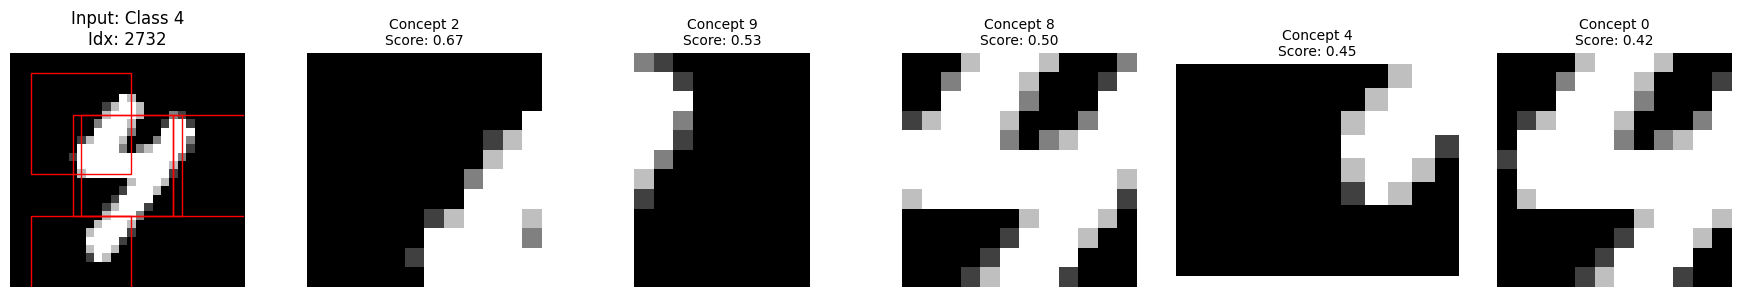

In [23]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np

def visualize_image_concepts(model, dataset, image_index=None, top_k=5, patch_size=12):
    """
    Visualizes a single image and the top K concepts that activate for it,
    showing the specific patch (crop) where each concept is looking.
    """
    if image_index is None:
        image_index = np.random.randint(len(dataset))

    image, label = dataset[image_index]
    image_input = image.unsqueeze(0).to(model._device) # Add batch dim

    # Get Model Internals
    model._backbone.eval()
    concepts = model._h.to(model._device)

    with torch.no_grad():
        # Get Spatial Features (Batch, Channels, H, W)
        feature_maps = model._backbone(image_input)

        # Get Global Concept Scores
        # Pool (B, C, H, W) -> (B, C)
        if len(feature_maps.shape) == 4:
            global_feats = torch.mean(feature_maps, dim=(2, 3))
        else:
            global_feats = feature_maps

        global_feats = global_feats.flatten(1)
        global_feats = global_feats / global_feats.norm(dim=1, keepdim=True)

        # Concept Scores: (1, Num_Concepts)
        concept_scores = torch.matmul(global_feats, concepts.T).squeeze()

        # Get Spatial Activation Maps for Top Concepts
        # Sort concepts by score
        top_scores, top_indices = torch.sort(concept_scores, descending=True)
        top_scores = top_scores[:top_k]
        top_indices = top_indices[:top_k]

        # Calculate CAMs only for these top concepts
        # Einsum: (1, Channels, H, W) x (K, Channels) -> (1, K, H, W)
        relevant_concepts = concepts[top_indices]
        cams = torch.einsum('bchw,kc->bkhw', feature_maps, relevant_concepts)

        # Upsample to image size
        cams_resized = F.interpolate(cams, size=image.shape[1:], mode='bilinear', align_corners=False)

    fig, axes = plt.subplots(1, top_k + 1, figsize=(3 * (top_k + 1), 3))

    # Plot Original Image
    ax_orig = axes[0]
    img_disp = image.permute(1, 2, 0).numpy()
    if img_disp.shape[2] == 1:
        ax_orig.imshow(img_disp.squeeze(), cmap='gray')
    else:
        ax_orig.imshow(img_disp)
    ax_orig.set_title(f"Input: Class {label}\nIdx: {image_index}", fontsize=12)
    ax_orig.axis('off')

    # Plot Top Concepts (Crops)
    for k in range(top_k):
        c_idx = top_indices[k].item()
        score = top_scores[k].item()

        # Find Hotspot (Max activation)
        cam = cams_resized[0, k, :, :]
        idx_flat = torch.argmax(cam)
        h_idx, w_idx = idx_flat // image.shape[1], idx_flat % image.shape[2]

        # Crop Patch
        h_start = max(0, h_idx.item() - patch_size // 2)
        w_start = max(0, w_idx.item() - patch_size // 2)
        h_end = min(image.shape[1], h_start + patch_size)
        w_end = min(image.shape[2], w_start + patch_size)

        patch = image[:, h_start:h_end, w_start:w_end]

        # Display Patch
        ax = axes[k + 1]
        patch_disp = patch.permute(1, 2, 0).numpy()

        if patch_disp.shape[2] == 1:
            ax.imshow(patch_disp.squeeze(), cmap='gray', vmin=0, vmax=1)
        else:
            ax.imshow(patch_disp)

        ax.set_title(f"Concept {c_idx}\nScore: {score:.2f}", fontsize=10)
        ax.axis('off')

        # Add a red box on the original image to show where it looked? (Optional)
        rect = plt.Rectangle((w_start, h_start), w_end-w_start, h_end-h_start,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax_orig.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Will pick a random image from Test set and show its top 5 concepts + patches
visualize_image_concepts(ph_cbm, test_ds, image_index=None, top_k=5, patch_size=12)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Codigo Basura - Reciclable

In [ ]:
# 1. Train backbone normally first (Black-box phase)
# 2. Extract activations 'A' for the training set
# A.shape = (n_samples, p_dimensions)

'''def discover_concepts(activations, n_concepts=20):
    # NMF ensures non-negative concept activation vectors [cite: 2956]
    model = NMF(n_components=n_concepts, init='random', random_state=0)
    U = model.fit_transform(activations)
    C = model.components_ # The concept basis vectors [cite: 2954]
    return torch.tensor(C).float()
'''

def discover_concepts(model, loader, n_concepts=20):
    model.eval()
    activations = []
    with torch.no_grad():
        for data, _ in loader:
            act = model(data.to(device))
            # NMF requires non-negative values; we use ReLU to ensure this
            activations.append(torch.relu(act).cpu().numpy())  # from https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/Craft/craft/craft_torch.py#L179


    A = np.concatenate(activations, axis=0)
    nmf = NMF(n_components=n_concepts, init='random', random_state=42, max_iter=5)
    nmf.fit(A)
    # GET THE CONCEPT ACTIVATIONS VECTORS (CAVs)



    return torch.tensor(nmf.components_).float().to(device), nmf

# Discover 20 latent concepts from the training activations
concept_matrix = discover_concepts(backbone, train_loader, n_concepts=20)

#https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/Craft/craft/craft_torch.py#L69
#https://github.com/lmb-freiburg/ucbm/blob/9d403a87398e5b538d75ac28ef1114c695a8371c/discover_concepts.py#L134

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
concept_matrix, nmf  = concept_matrix

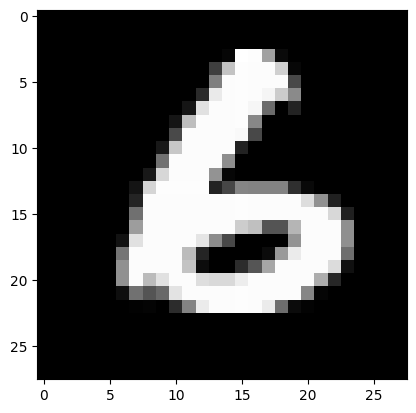

In [ ]:
#get one image
data_iter = iter(train_loader)
img, label = next(data_iter)
plt.imshow(img[0][0], cmap='gray')
plt.show()
img = img.to(device)  # shape: (1, 1, 28, 28)

with torch.no_grad():
    act = backbone(img)          # shape: (1, 128)
    act = torch.relu(act)

act_np = act.cpu().numpy()       # shape: (1, 128)


In [ ]:
W_img = nmf.fit_transform(act_np)
print("W: ",W_img.shape)
H_img = nmf.components_
print("H: ",H_img.shape)

"""
Result:
W (64, 20) where 64 are the batch in the dataloader in the discover_concepts function, 20 are the concepts
H (20, 128) where 20 are the concepts, and 128 are the features/head of the CNN backbone model.

"""

W:  (64, 20)
H:  (20, 128)


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


'\nResult:\nW (64, 20) where 64 are the batch in the dataloader in the discover_concepts function, 20 are the concepts\nH (20, 128) where 20 are the concepts, and 128 are the features/head of the CNN backbone model.\n'

Concept 8: 0.5284
Concept 2: 0.1951
Concept 0: 0.1185
Concept 6: 0.0555
Concept 15: 0.0477
Concept 11: 0.0354
Concept 5: 0.0279
Concept 18: 0.0254
Concept 13: 0.0235
Concept 19: 0.0197
Concept 7: 0.0020
Concept 16: 0.0008
Concept 1: 0.0000
Concept 3: 0.0000
Concept 4: 0.0000
Concept 9: 0.0000
Concept 10: 0.0000
Concept 12: 0.0000
Concept 14: 0.0000
Concept 17: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 5 reached. Increase it to improve convergence.
  warnings.warn(


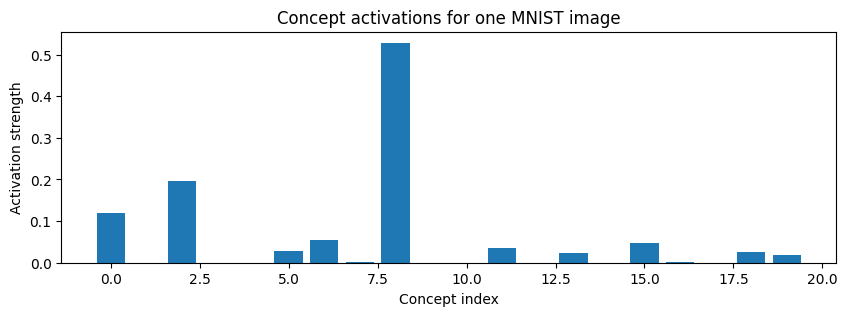

In [ ]:
W_img = nmf.transform(act_np)    # shape: (1, 20)
concept_dict = {f"Concept {i}": val for i, val in enumerate(W_img[0])}
sorted_concepts = sorted(concept_dict.items(), key=lambda x: x[1], reverse=True)
for concept, value in sorted_concepts:
    print(f"{concept}: {value:.4f}")

plt.figure(figsize=(10, 3))
plt.bar(range(20), W_img[0])
plt.xlabel("Concept index")
plt.ylabel("Activation strength")
plt.title("Concept activations for one MNIST image")
plt.show()


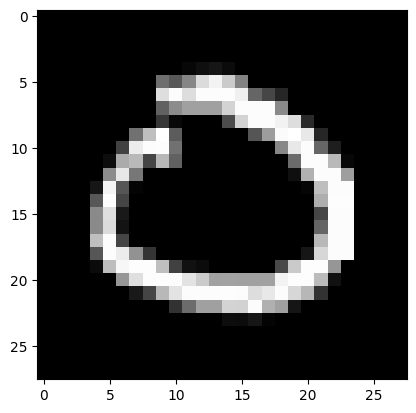

In [ ]:
#get one image
data_iter = iter(train_loader)
img, label = next(data_iter)
plt.imshow(img[0][0], cmap='gray')
plt.show()
img = img.to(device)  # shape: (1, 1, 28, 28)

with torch.no_grad():
    act = backbone(img)          # shape: (1, 128)
    act = torch.relu(act)

act_np = act.cpu().numpy()       # shape: (1, 128)


how to know the meaning of those concepts

### The Interpretable Classifier (Reasoning)

In [ ]:
class CBMClassifier(nn.Module):
    def __init__(self, concept_matrix, n_classes=10):
        super(CBMClassifier, self).__init__()
        self.concepts = nn.Parameter(concept_matrix, requires_grad=False)
        self.offset = nn.Parameter(torch.zeros(concept_matrix.shape[0])) # Trainable offset 'o' [cite: 2983]
        self.gate_dropout = nn.Dropout(p=0.2) # Reducing over-reliance [cite: 2993]
        self.linear = nn.Linear(concept_matrix.shape[0], n_classes)

    def forward(self, activations):
        # Calculate normalized cosine similarity [cite: 2976]
        norm_act = torch.nn.functional.normalize(activations, dim=1)
        norm_concepts = torch.nn.functional.normalize(self.concepts, dim=1)
        proj = torch.matmul(norm_act, norm_concepts.T)

        # Gating mechanism: pi(x) = max(0, proj - o) [cite: 2982]
        pi = torch.max(torch.zeros_like(proj), proj - self.offset)
        pi = self.gate_dropout(pi)

        return self.linear(pi), pi

### Training with Sparsity Regularization

In [ ]:
def cbm_loss(outputs, targets, pi, model, lambda_pi=1e-4, lambda_w=1e-4):
    criterion = nn.CrossEntropyLoss()
    task_loss = criterion(outputs, targets)

    # Elastic Net Regularization [cite: 2977]
    def elastic_net(weights, alpha=0.99):
        l1 = torch.norm(weights, 1)
        l2 = torch.norm(weights, 2)
        return alpha * l1 + (1 - alpha) * 0.5 * l2

    reg_pi = elastic_net(pi)
    reg_w = elastic_net(model.linear.weight)

    return task_loss + lambda_pi * reg_pi + lambda_w * reg_w